In [28]:
%matplotlib inline
import pylab as plt
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import functools
import datetime
import os
from scipy.stats import zscore
import scipy
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

import cmlreaders as cml
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import morlet
from ptsa.data.filters import ButterworthFilter

#from Assignment3_Module import PowerSpectra
# We load the dataframe for all sessions.
exp = 'ltpFR2'
df = cml.get_data_index('ltp', rootdir='/').query('experiment == @exp')
morlet_reps = 6


res_dir = 'results/Proj/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
final_subs = df['subject'].unique()

In [3]:
f_subs = final_subs[:50]

In [4]:
f_subs

array(['LTP093', 'LTP106', 'LTP115', 'LTP117', 'LTP122', 'LTP123',
       'LTP133', 'LTP138', 'LTP187', 'LTP207', 'LTP210', 'LTP228',
       'LTP229', 'LTP236', 'LTP242', 'LTP246', 'LTP249', 'LTP250',
       'LTP251', 'LTP258', 'LTP259', 'LTP260', 'LTP265', 'LTP269',
       'LTP273', 'LTP274', 'LTP278', 'LTP279', 'LTP280', 'LTP281',
       'LTP283', 'LTP285', 'LTP287', 'LTP290', 'LTP293', 'LTP295',
       'LTP296', 'LTP297', 'LTP298', 'LTP299', 'LTP300', 'LTP301',
       'LTP302', 'LTP303', 'LTP304', 'LTP305', 'LTP306', 'LTP307',
       'LTP308', 'LTP309'], dtype=object)

In [5]:
l_subs = final_subs[50:100]

In [6]:
l_subs

array(['LTP310', 'LTP311', 'LTP312', 'LTP313', 'LTP314', 'LTP315',
       'LTP316', 'LTP317', 'LTP318', 'LTP319', 'LTP320', 'LTP321',
       'LTP322', 'LTP323', 'LTP324', 'LTP325', 'LTP326', 'LTP327',
       'LTP328', 'LTP329', 'LTP330', 'LTP331', 'LTP334', 'LTP336',
       'LTP337', 'LTP338', 'LTP339', 'LTP340', 'LTP341', 'LTP342',
       'LTP343', 'LTP344', 'LTP346', 'LTP347', 'LTP348', 'LTP349',
       'LTP352', 'LTP353', 'LTP354', 'LTP355', 'LTP356', 'LTP357',
       'LTP358', 'LTP359', 'LTP360', 'LTP361', 'LTP362', 'LTP363',
       'LTP364', 'LTP365'], dtype=object)

In [7]:
import cmldask.CMLDask as da
import cmldask
from dask.distributed import wait, as_completed, progress

def RunDask(func, args=[], smokescreen=False, dask_args={'job_name': "converts", 
                                                         'memory_per_job': "10GB", 
                                                         'max_n_jobs': 10,
                                                         'death_timeout': 600,
                                                         'log_directory': 'results/Proj/DaskLogs'}):
    client = da.new_dask_client(**dask_args)
    if smokescreen: args = args[:2]
    futures = client.map(func, *args)
    progress(futures)
    return futures

In [8]:
def SaveFig(basename):
    plt.savefig(basename+'.png')
    plt.savefig(basename+'.pdf')

In [9]:
def Log(s):
    date = datetime.datetime.now().strftime('%F_%H-%M-%S')
    output = date + ': ' + str(s)
    with open('analysis_log.txt', 'a') as logfile:
        print(output)
        logfile.write(output+'\n')

In [10]:
def LogDFException(row, e):
    rd = row._asdict()
    Log('Sub: '+str(rd['subject'])+', Exp: '+str(rd['experiment'])+', Sess: '+\
        str(rd['session'])+', '+e.__class__.__name__+', '+str(e))

In [11]:
def SubjectDataFrames(sub_list, exp=['ltpFR2']):
    if isinstance(sub_list, str):
        sub_list = [sub_list]
    if isinstance(exp, str):
        exp = [exp]
    
    df = get_data_index('all').query('experiment in @exp')
    indices_list = [df['subject']==sub for sub in sub_list]
    indices = functools.reduce(lambda x,y: x|y, indices_list)
    df_matched = df[indices]
    return df_matched

In [12]:
def CMLReadDFRow(row):
    '''for row in df.itertuples():
            reader = CMLReadDFRow(row)
    '''
    rd = row._asdict()
    return CMLReader(rd['subject'], rd['experiment'], rd['session'], \
                     rd['montage'], rd['localization'])

In [13]:
def StartFig():
    plt.figure()
    plt.rcParams.update({'font.size': 12})

In [14]:
scalp_subs = ['LTP093', 'LTP117', 'LTP123', 'LTP133', 'LTP228', 
              'LTP246', 'LTP249', 'LTP251', 'LTP258', 'LTP259', 
              'LTP265', 'LTP269', 'LTP279', 'LTP280', 'LTP285', 
              'LTP287', 'LTP293', 'LTP296', 'LTP297', 'LTP302', 
              'LTP304', 'LTP307', 'LTP310', 'LTP311', 'LTP317', 
              'LTP318', 'LTP322', 'LTP327', 'LTP329', 'LTP330']

my_subs = scalp_subs[:15]


scalp3 = scalp_subs[0:3]

freqs = np.unique(np.round(np.logspace(np.log10(1), np.log10(300), 17)))

In [15]:
cdf = pd.read_excel('c_rating.xlsx')
conc_df = cdf[['Word', 'Conc.M', 'Conc.SD']]
conc_df['Word'] = conc_df['Word'].str.upper()
conc_df = conc_df.rename(columns={'Conc.M': 'conc_rating', 'Conc.SD': 'conc_sd'})

In [16]:
import warnings
warnings.filterwarnings("ignore")

def GetElectrodes(sub):
    df_sub = SubjectDataFrames(sub)
    reader = CMLReadDFRow(next(df_sub.itertuples()))
    evs = reader.load('events')
    enc_evs = evs[evs.type=='WORD']
    eeg = reader.load_eeg(events=enc_evs, rel_start=0, rel_stop=500, clean=True)
    return eeg.to_ptsa().channel.values

all_scalp_electrodes = GetElectrodes(scalp_subs[1])
np.save(res_dir + 'all_scalp_elecs.npy',all_scalp_electrodes)

Opening raw data file /protocols/ltp/subjects/LTP117/experiments/ltpFR2/sessions/0/ephys/current_processed/LTP117 20140612 1441.1_clean_raw.fif...
    Range : 0 ... 2870221 =      0.000 ...  5740.442 secs
Ready.
Reading 0 ... 2870221  =      0.000 ...  5740.442 secs...


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/tag.py:427: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  ch_name = ch_name[:np.argmax(ch_name == b'')].tostring()
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/tag.py:427: DeprecationWarning: tostring() is deprecated. Use tob

576 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 576 events and 251 original time points ...


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
/usr/g

0 bad epochs dropped


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/mne/io/pick.py:360: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
/usr/g

In [17]:
#copy to manipulate

def PowerSpectra2(subjects, electrodes, freqs, avg_ref=False, ref_region_idx=None,
                 log_power=False, zscore=False, exp='ltpFR2',
                 bin_elecs=True, internal_bipolar=False, use_pairs=True,
                 elec_masks=False, debug=False):
    import warnings
    warnings.filterwarnings("ignore")

    buf_ms = 1000
    range_left_ms = 0
    range_right_ms = 1600
    morlet_reps = 6
    crec_results = []
    cnrec_results = []
    arec_results = []
    anrec_results = []


    for sub in subjects:
        df_sub = SubjectDataFrames(sub, exp).iloc[:1] if debug else SubjectDataFrames(sub, exp)
        sub_crec_powers = np.zeros(len(freqs))
        sub_cnrec_powers = np.zeros(len(freqs))
        sub_arec_powers = np.zeros(len(freqs))
        sub_anrec_powers = np.zeros(len(freqs))
        

        first_run = True
        first_channel_flags = None
        num_channels_found = 0
        df_per_sub = 0
        mask_index = -1
        
#         print('iter')
        for row in df_sub.itertuples():
            mask_index += 1
            try:
                reader = CMLReadDFRow(row)
                # This does not work for this data set,
                # so we will get these from load_eeg(...).to_ptsa() later.
                evs = reader.load('events')
#                 print('events')
                enc_evs = evs[evs.type=='WORD']
                #add new column with concrettess rating
                enc_evs = pd.merge(enc_evs, conc_df, left_on='item_name', right_on='Word')

                # Drop the 'Word' column as it is redundant with 'item_name'
                enc_evs.drop('Word', axis=1, inplace=True)
                conc_m_50th_percentile = enc_evs['conc_rating'].quantile(0.5)
        
                # Create a new column called conc_indicator
                enc_evs['conc_indicator'] = (enc_evs['conc_rating'] >= conc_m_50th_percentile).astype(int)
                
                conc_evs = enc_evs[enc_evs['conc_indicator'] == 1]
                abs_evs = enc_evs[enc_evs['conc_indicator'] == 0]
                
                if np.sum(enc_evs.recalled == True) == 0:
                    raise IndexError('No recalled events')
                if np.sum(enc_evs.recalled == False) == 0:
                    raise IndexError('No non-recalled events')


                    

                eeg = reader.load_eeg(events=enc_evs, rel_start=-range_left_ms - buf_ms, \
                    rel_stop=range_right_ms + buf_ms, clean=True)
                
                if len(eeg.events) != enc_evs.shape[0]:
                    raise IndexError(str(len(eeg.events)) + ' eeg events for ' + \
                                     str(enc_evs.shape[0]) + ' encoding events')
            
                
                
                if internal_bipolar:
                    # Bipolar reference to nearest labeled electrode
                    eeg.data -= np.roll(eeg.data, 1, 1)

                sr = eeg.samplerate
                print('sampling rate (Hz)',sr)
            
                eeg_ptsa = eeg.to_ptsa()
                del eeg
                
                if elec_masks:
                    if electrodes[mask_index] is None:
                        raise ValueError('No channel mask available for session ' + \
                                         str(mask_index))
                    if isinstance(electrodes[mask_index], np.ndarray):
                        channel_flags = electrodes[mask_index].tolist()
                    else:
                        channel_flags = electrodes[mask_index]
                else:
                    channels = eeg_ptsa.channel.values
                    channel_flags = [c in electrodes for c in channels]
                
                if np.sum(channel_flags)==0:
                    if elec_masks:
                        raise IndexError('No channels for region index '+str(mask_index))
                    else:
                        raise IndexError('No matching channels found for '+str(electrodes))
                
#                 print('before eeg_chan')
#                 print(len(channel_flags))
#                 print(eeg_ptsa.shape)
                eeg_chan = eeg_ptsa[:,channel_flags,:]
#                 print('after eeg_chan')
                del eeg_ptsa
                
                freq_range = [58., 62.]
                b_filter = ButterworthFilter(freq_range=freq_range, filt_type='stop', order=4)
                eeg_filtered = b_filter.filter(eeg_chan)
                del eeg_chan
                # PTSA 2
#                 b_filter = ButterworthFilter(timeseries=eeg_chan, freq_range=freq_range, filt_type='stop', order=4)
#                 eeg_filtered = b_filter.filter()
#                 del eeg_chan
#                 print(morlet_reps)
#                 print(freqs)
#                 print(eeg_filtered.time)
                wf = morlet.MorletWaveletFilter(freqs=freqs, width=morlet_reps, 
                                                output='power', complete=True)
                powers_plusbuf = wf.filter(eeg_filtered)
                del eeg_filtered
            
                # PTSA 2
#                 wf = morlet.MorletWaveletFilter(timeseries=eeg_filtered, freqs=freqs, \
#                     width=morlet_reps, output=['power'], complete=True)

                # remove buffer
                # freqs, events, elecs, and time
                powers = powers_plusbuf[:, :, :, int((buf_ms/1000)*sr):-1*int((buf_ms/1000)*sr)]
                del powers_plusbuf
                
                if log_power:
                    powers = np.log10(powers)
                
                # Average over time
                powers = np.mean(powers, (3))
                
                
                conc_powers = powers.sel(conc_indicator = 1)
                abs_powers= powers.sel(conc_indicator = 0)
                
                # Across events
                if zscore:
                    conc_powers = scipy.stats.zscore(conc_powers, 1, ddof=1)
                    abs_powers = scipy.stats.zscore(abs_powers, 1, ddof=1)
                    
                
                
                
                if bin_elecs:
                    #concrete word avgs
                    crec_powers = np.mean(conc_powers[:,conc_evs.recalled == True,:].data, (1,2))
                    cnrec_powers = np.mean(conc_powers[:,conc_evs.recalled == False,:].data, (1,2))


                    #abstract word avgs
                    arec_powers = np.mean(abs_powers[:,abs_evs.recalled == True,:].data, (1,2))
                    anrec_powers = np.mean(abs_powers[:,abs_evs.recalled == False,:].data, (1,2))
                    del conc_powers
                    del abs_powers
                else:
                    if first_run==True:
                        first_run = False
                        first_channel_flags = channel_flags
                        num_channels_found = powers.shape[2]
                        
                        
                        sub_crec_powers = np.zeros((powers.shape[0], powers.shape[2]))
                        sub_cnrec_powers = np.zeros((powers.shape[0], powers.shape[2]))
                        sub_arec_powers = np.zeros((powers.shape[0], powers.shape[2]))
                        sub_anrec_powers = np.zeros((powers.shape[0], powers.shape[2]))
                        
#                         sub_rec_powers = np.zeros((powers.shape[0], powers.shape[2]))
#                         sub_nrec_powers = np.zeros((powers.shape[0], powers.shape[2]))
                    else:
                        if np.any(first_channel_flags != channel_flags):
                            raise IndexError('Mismatched electrodes for subject')
                        if num_channels_found != powers.shape[2]:
                            raise IndexError('Inconsistent number of electrodes found')
                    
                    #concrete word avgs
                    crec_powers = np.mean(conc_powers[:,conc_evs.recalled == True,:].data, (1))
                    cnrec_powers = np.mean(conc_powers[:,conc_evs.recalled == False,:].data, (1))
                    
                    #abstract word avgs
                    arec_powers = np.mean(abs_powers[:,abs_evs.recalled == True,:].data, (1))
                    anrec_powers = np.mean(abs_powers[:,abs_evs.recalled == False,:].data, (1))
                    del conc_powers
                    del abs_powers
                
                if np.any(np.isnan(crec_powers)) or np.any(np.isnan(cnrec_powers)) or np.any(np.isnan(arec_powers)) or np.any(np.isnan(anrec_powers)):
                    print('NaNs detected in powers: subject', sub, 'session', row.session)
                    print('rec_powers', crec_powers)
                    print('nrec_powers', cnrec_powers)
                    print('rec_powers', arec_powers)
                    print('nrec_powers', anrec_powers)
                    raise ValueError('nan values in eeg power')
                    
                #appends concrete powers
                sub_crec_powers += crec_powers
                sub_cnrec_powers += cnrec_powers
                
                #appends abstract powers
                sub_arec_powers += arec_powers
                sub_anrec_powers += anrec_powers
    
                df_per_sub += 1
            except Exception as e:
                print(e)
                LogDFException(row, e)
                if debug: raise e

        print('df_per_sub', df_per_sub)
        sub_crec_powers /= df_per_sub
        sub_cnrec_powers /= df_per_sub
        sub_arec_powers /= df_per_sub
        sub_anrec_powers /= df_per_sub
        
        crec_results.append(sub_crec_powers)
        cnrec_results.append(sub_cnrec_powers)
        arec_results.append(sub_arec_powers)
        anrec_results.append(sub_anrec_powers)
        
    return (freqs, crec_results, cnrec_results, arec_results, anrec_results)

In [18]:
#theta = 8
#alpha = 12
#beta = 25
#gamma = 103

In [26]:
def LogZPowerSpectra(sub):
    import numpy as np
    import os
    
    # SubjectDataFrames, CMLReadDFRow, and PowerSpectra in Assignment3_Module.py
    # (Along with the necessary imports for those functions)
   
    
    fileout = res_dir + os.path.join('gamma3_final',  sub + '.npy')
    try:
        elec_filename = res_dir + ('all_scalp_elecs.npy')
        elecs = np.load(elec_filename, allow_pickle=True)
        
        (freqs, crec_results, cnrec_results, arec_results, anrec_results) = PowerSpectra2([sub], elecs, [147],  log_power = True, zscore=True, bin_elecs=False)
        np.save(fileout, [freqs, crec_results, cnrec_results, arec_results, anrec_results])
    except Exception as e:
        np.save(fileout, ['Exception', str(e.__class__), str(e)])
        print(e)
        return
    
    return

In [27]:
subs = final_subs
futures = RunDask(LogZPowerSpectra, [subs])
progress(futures)

Unique port for ijordan is 51528
{'dashboard_address': ':51528'}
To view the dashboard, run: 
`ssh -fN ijordan@rhino2.psych.upenn.edu -L 7000:192.168.86.126:34123` in your local computer's terminal (NOT rhino) 
and then navigate to http://localhost:7000 in your browser


VBox()

In [21]:
errors = da.get_exceptions(futures, range(40))
print(errors)

                                               exception traceback_obj
param                                                                 
13     KilledWorker('LogZPowerSpectra-85f8b18b4517b44...          None
14     KilledWorker('LogZPowerSpectra-7257e4e3e8d4c71...          None
17     KilledWorker('LogZPowerSpectra-d50c317de06e9c8...          None
18     KilledWorker('LogZPowerSpectra-2a3d5f0ede8eeb0...          None
21     KilledWorker('LogZPowerSpectra-bfd67024144ed47...          None
22     KilledWorker('LogZPowerSpectra-7d46b950c73375f...          None
23     KilledWorker('LogZPowerSpectra-7a5c6aa0b9f4b95...          None
24     KilledWorker('LogZPowerSpectra-c8fe53dd2e06c12...          None
25     KilledWorker('LogZPowerSpectra-02162dbbb653a71...          None
26     KilledWorker('LogZPowerSpectra-9d9fd2735b44db4...          None
27     KilledWorker('LogZPowerSpectra-12006e48b7c23c3...          None
28     KilledWorker('LogZPowerSpectra-4a76c47f724ae28...          None
29    

In [69]:
filein = res_dir + os.path.join('collection_logZ', sub + '.npy')
loaded = np.load(filein, allow_pickle=True)
(freqs, crec_results, cnrec_results, arec_results, anrec_results) = loaded

In [24]:
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
from ptsa_plot.ptsa_plot.topo import topoplot
import matplotlib.pyplot as plt

def topo(crec_lst, arec_lst):
    # Convert data to numpy arrays
    crec_lst = np.array(crec_lst)
    arec_lst = np.array(arec_lst)

    # Calculate mean values for each electrode
    crec_elecs = np.mean(crec_lst, axis=0)
    arec_elecs = np.mean(arec_lst, axis=0)
    car_diff_elecs = crec_elecs - arec_elecs

    # Perform independent two-sample t-test with unequal variance
    car_tstats, car_pvals = scipy.stats.ttest_ind(crec_lst, arec_lst, equal_var=False, axis=0)

    # Perform Benjamini-Hochberg FDR correction
    cres = statsmodels.stats.multitest.multipletests(car_pvals, 0.05, method='fdr_bh')
    FDR_sig = cres[0]
    pval_corr = cres[1]

    # Load electrode layout
    with open('./ptsa_plot/ptsa_plot/electrode_layouts/HCGSN128.dat', 'r') as sensorfile:
        angles, radii = sensorfile.readlines()
        sensors = (np.r_[np.array([np.float(a) for a in angles.strip().split()]), 0], \
                   np.r_[[np.float(r) for r in radii.strip().split()], 0])

    elec_mapping = [int(s[1:]) for s in all_scalp_electrodes]

    # Generate topographic plot of difference values with FDR-corrected significance markers
    avg_diff = np.mean(car_diff_elecs)
    plot_powers = np.zeros(129)
    for i in range(len(car_diff_elecs)):
        plot_powers[elec_mapping[i]-1] = car_diff_elecs[i]

    pmin = min(car_diff_elecs)
    pmax = max(car_diff_elecs)

    sigmarks = [['','X'][sig] for sig in FDR_sig]

    fig, ax = plt.subplots(1,1)
    topoplot(sensors=sensors, values=plot_powers, labels=sigmarks, axes=ax, cmap='bwr')
    plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(pmin, pmax), cmap='bwr'))

    # Return the FDR-corrected p-values
    return pval_corr

In [ ]:
# I.5 Plots

# Topographical map example

with open('./ptsa_plot/ptsa_plot/electrode_layouts/HCGSN128.dat', 'r') as sensorfile:
    angles, radii = sensorfile.readlines()
    sensors = (np.r_[np.array([np.float(a) for a in angles.strip().split()]), 0], \
               np.r_[[np.float(r) for r in radii.strip().split()], 0])

elec_mapping = [int(s[1:]) for s in all_scalp_electrodes]

fig, ax = plt.subplots(1,1)
topoplot(sensors=sensors, labels=range(1,130), axes=ax)
SaveFig(res_dir + 'Fig_I5a')

avg_diff = np.mean(diff_elecs)
plot_powers = np.zeros(129)
for i in range(len(diff_elecs)):
    plot_powers[elec_mapping[i]-1] = diff_elecs[i]

pmin = min(diff_elecs)
pmax = max(diff_elecs)

sigmarks = [['','X'][sig] for sig in FDR_sig]

fig, ax = plt.subplots(1,1)
topoplot(sensors=sensors, values=plot_powers, labels=sigmarks, axes=ax, cmap='bwr')
import matplotlib
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(pmin, pmax), cmap='bwr'))
SaveFig(res_dir + 'Fig_I5b')

[0.69802315 0.69802315 0.69802315 0.69802315 0.69802315 0.74515626
 0.74059115 0.69802315 0.69802315 0.69802315 0.74515626 0.70767954
 0.69802315 0.69802315 0.69802315 0.69802315 0.69802315 0.69802315
 0.74515626 0.69802315 0.69802315 0.69802315 0.69802315 0.82771943
 0.74515626 0.69802315 0.69802315 0.69802315 0.69802315 0.74526136
 0.69802315 0.70767954 0.69802315 0.69802315 0.69802315 0.69802315
 0.69802315 0.69802315 0.69802315 0.69802315 0.69802315 0.69802315
 0.74059115 0.74526136 0.69802315 0.70767954 0.69802315 0.69802315
 0.69802315 0.69802315 0.69802315 0.69802315 0.69802315 0.77064233
 0.69802315 0.69802315 0.70767954 0.69802315 0.92122892 0.69802315
 0.69802315 0.69802315 0.74526136 0.70767954 0.7641378  0.69802315
 0.69802315 0.71839166 0.89097878 0.79872652 0.74059115 0.74515626
 0.95175666 0.88645144 0.74515626 0.69802315 0.69802315 0.69802315
 0.7641378  0.89097878 0.7641378  0.70767954 0.69802315 0.69802315
 0.69802315 0.9104487  0.88645144 0.74062601 0.74515626 0.6980

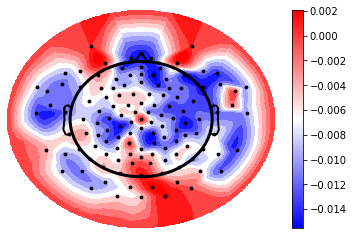

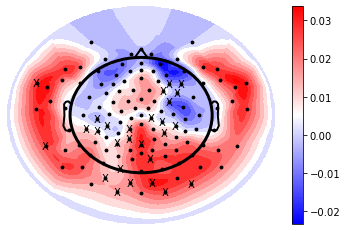

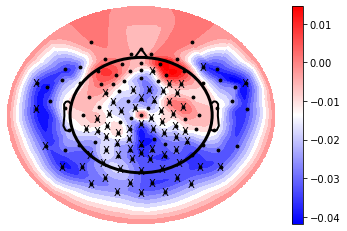

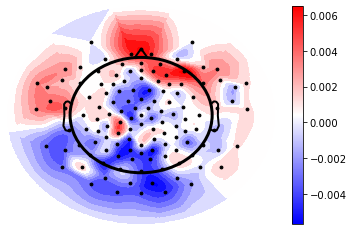

In [25]:
#here i would have tp change file in depending on name of frequcy collecting
import matplotlib

crec_lst = []
cnrec_lst = []
arec_lst = []
anrec_lst = []

for sub in subs:
    filein = res_dir + os.path.join('gamma2_final', sub + '.npy')
    loaded = np.load(filein, allow_pickle=True)
    (freqs, crec_results, cnrec_results, arec_results, anrec_results) = loaded
    if not isinstance(crec_results, np.ndarray) or not isinstance(cnrec_results, np.ndarray) or not isinstance(arec_results, np.ndarray) or \
        not isinstance(anrec_results, np.ndarray):
        Log('Discarding '+sub+' at I.5 reload due to earlier data error')
        print(rec_powers)
        continue
    #print('rec_powers', rec_powers)
    #print('nrec_powers', nrec_powers)
    # Only one frequency, average over it to remove it.
    
    #concrete
    crec_results = np.mean(np.ravel(crec_results), (0))[0]
    cnrec_results = np.mean(np.ravel(cnrec_results), (0))[0]
    crec_lst.append(crec_results)
    cnrec_lst.append(cnrec_results)
    
    #abstract
    arec_results = np.mean(np.ravel(arec_results), (0))[0]
    anrec_results = np.mean(np.ravel(anrec_results), (0))[0]
    arec_lst.append(arec_results)
    anrec_lst.append(anrec_results)
data_lst = [crec_lst, cnrec_lst, arec_lst, anrec_lst]    

import itertools
i=0
for combo in itertools.combinations(data_lst, 2):
    # Extract the two data sets
    i+=1
    if i == 1 or i == 6:
        continue
    else:
        data1 = combo[0]
        data2 = combo[1]
        l = topo(data1, data2)
        SaveFig(res_dir + os.path.join('gamma2_final',  'Fig1' + str(i)))
        print(l)



In [ ]:
import itertools
i=0
for combo in itertools.combinations(data_lst, 2):
    # Extract the two data sets
    i+=1
    if i == 1 or i == 4:
        continue
    else:
        data1 = combo[0]
        data2 = combo[1]
        l = topo(data1, data2)
        print(l)

array([1.93773224e-01, 2.53587582e-02, 1.01867222e-03, 7.74108727e-04,
       5.29479006e-04, 1.18844758e-05, 3.70483156e-05, 9.85571322e-04,
       6.20202751e-04, 5.29479006e-04, 4.47068197e-04, 4.00968933e-05,
       1.49631753e-03, 8.29360104e-04, 5.93276258e-04, 6.39303287e-03,
       1.45075348e-03, 3.18843118e-03, 1.05684879e-03, 1.42374980e-03,
       2.11873834e-03, 1.52698270e-03, 1.52698270e-03, 9.32138439e-03,
       2.28673947e-03, 1.42374980e-03, 1.01867222e-03, 4.47068197e-04,
       9.93954104e-05, 1.82648017e-01, 1.09200988e-01, 3.16357287e-02,
       2.35144227e-02, 1.69004298e-03, 4.00968933e-05, 1.44728821e-01,
       7.58821863e-02, 5.74816863e-02, 1.82580803e-02, 4.06096269e-03,
       2.42300353e-02, 6.17484131e-02, 6.15530600e-03, 1.16593929e-02,
       4.94228499e-03, 4.06096269e-03, 6.15530600e-03, 4.31200252e-04,
       1.65924040e-03, 1.47713650e-03, 1.92581614e-04, 2.95888949e-05,
       5.29479006e-04, 3.67535799e-03, 1.92075088e-04, 4.17836618e-04,
      

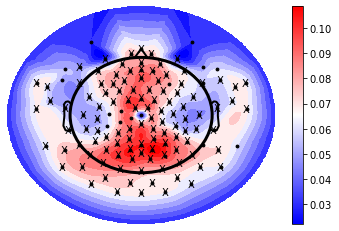

In [30]:
topo(cnrec_lst, arec_lst)

In [48]:
# Concrete Powers by:
# subject, electrode
crec_lst = np.array(crec_lst)
cnrec_lst = np.array(cnrec_lst)
crec_elecs = np.mean(crec_lst, (0))
cnrec_elecs = np.mean(cnrec_lst, (0))
cdiff_elecs = crec_elecs - cnrec_elecs


ctstats, cpvals = scipy.stats.ttest_ind(crec_lst, cnrec_lst, equal_var=False, axis=0)

print('Uncorrected:\n', cpvals < 0.05)
import statsmodels.stats.multitest
# Benjamini-Hochberg FDR correction
cres = statsmodels.stats.multitest.multipletests(cpvals, 0.05, method='fdr_bh')
FDR_sig = cres[0]
pval_corr = cres[1]
print('False discovery rate corrected:\n', FDR_sig)
print('Corrected pvals:\n', pval_corr)
print('Number significant:', np.sum(FDR_sig))

Uncorrected:
 [False  True False  True False False False False False False False False
  True False False  True False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False  True  True False False False  True False False False False
 False False False False  True False False False  True False False False
 False False  True  True False  True  True False  True False False  True
 False False False False False  True False False False False  True  True
 False False False False  True  True  True False False False False False
  True  True False False]
False discovery rate corrected:
 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [49]:
# Abstract Powers by:
# subject, electrode
arec_lst = np.array(arec_lst)
anrec_lst = np.array(anrec_lst)
arec_elecs = np.mean(arec_lst, (0))
anrec_elecs = np.mean(anrec_lst, (0))
adiff_elecs = arec_elecs - anrec_elecs

tstats, pvals = scipy.stats.ttest_ind(arec_lst, anrec_lst, equal_var=False, axis=0)

print('Uncorrected:\n', pvals < 0.05)
import statsmodels.stats.multitest
# Benjamini-Hochberg FDR correction
res = statsmodels.stats.multitest.multipletests(pvals, 0.05, method='fdr_bh')
FDR_sig = res[0]
pval_corr = res[1]
print('False discovery rate corrected:\n', FDR_sig)
print('Corrected pvals:\n', pval_corr)
print('Number significant:', np.sum(FDR_sig))

Uncorrected:
 [False False  True  True False False False  True  True  True False False
  True  True  True  True  True  True False False False  True False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False  True False False  True  True  True False False False
 False False False False False False False False  True False False  True
 False False  True  True False  True  True  True  True False False False
  True  True False False False False False False  True  True  True False
  True  True False False  True  True  True  True False False False False
  True  True  True False]
False discovery rate corrected:
 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

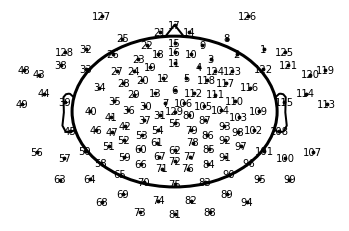

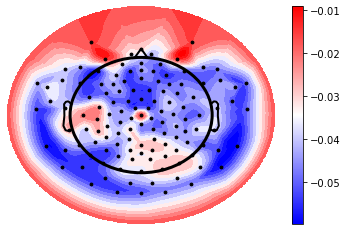

In [50]:
from ptsa_plot.ptsa_plot.topo import topoplot

with open('./ptsa_plot/ptsa_plot/electrode_layouts/HCGSN128.dat', 'r') as sensorfile:
    angles, radii = sensorfile.readlines()
    sensors = (np.r_[np.array([np.float(a) for a in angles.strip().split()]), 0], \
               np.r_[[np.float(r) for r in radii.strip().split()], 0])

elec_mapping = [int(s[1:]) for s in all_scalp_electrodes]

fig, ax = plt.subplots(1,1)
topoplot(sensors=sensors, labels=range(1,130), axes=ax)
#SaveFig(res_dir + 'Fig_I5a')

avg_diff = np.mean(adiff_elecs)
plot_powers = np.zeros(129)
for i in range(len(adiff_elecs)):
    plot_powers[elec_mapping[i]-1] = adiff_elecs[i]

pmin = min(adiff_elecs)
pmax = max(adiff_elecs)

sigmarks = [['','X'][sig] for sig in FDR_sig]

fig, ax = plt.subplots(1,1)
topoplot(sensors=sensors, values=plot_powers, labels=sigmarks, axes=ax, cmap='bwr')
import matplotlib
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(pmin, pmax), cmap='bwr'))
#SaveFig(res_dir + 'Fig_I5b')

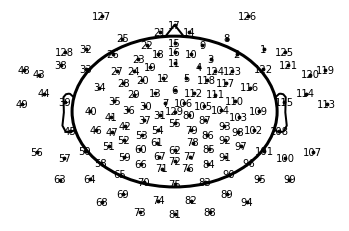

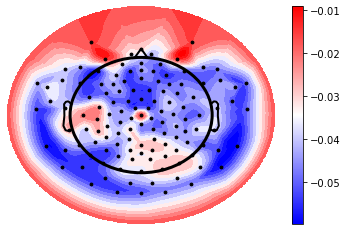

In [50]:
from ptsa_plot.ptsa_plot.topo import topoplot

with open('./ptsa_plot/ptsa_plot/electrode_layouts/HCGSN128.dat', 'r') as sensorfile:
    angles, radii = sensorfile.readlines()
    sensors = (np.r_[np.array([np.float(a) for a in angles.strip().split()]), 0], \
               np.r_[[np.float(r) for r in radii.strip().split()], 0])

elec_mapping = [int(s[1:]) for s in all_scalp_electrodes]

fig, ax = plt.subplots(1,1)
topoplot(sensors=sensors, labels=range(1,130), axes=ax)
#SaveFig(res_dir + 'Fig_I5a')

avg_diff = np.mean(adiff_elecs)
plot_powers = np.zeros(129)
for i in range(len(adiff_elecs)):
    plot_powers[elec_mapping[i]-1] = adiff_elecs[i]

pmin = min(adiff_elecs)
pmax = max(adiff_elecs)

sigmarks = [['','X'][sig] for sig in FDR_sig]

fig, ax = plt.subplots(1,1)
topoplot(sensors=sensors, values=plot_powers, labels=sigmarks, axes=ax, cmap='bwr')
import matplotlib
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(pmin, pmax), cmap='bwr'))
#SaveFig(res_dir + 'Fig_I5b')

In [ ]:
#Concrete Recall vs Abstract Recall
crec_lst = np.array(crec_lst)
arec_lst = np.array(arec_lst)
crec_elecs = np.mean(crec_lst, (0))
arec_elecs = np.mean(arec_lst, (0))
car_diff_elecs = crec_elecs - arec_elecs

car_tstats, car_pvals = scipy.stats.ttest_ind(crec_lst, arec_lst, equal_var=False, axis=0)

print('Uncorrected:\n', car_pvals < 0.05)
import statsmodels.stats.multitest
# Benjamini-Hochberg FDR correction
cres = statsmodels.stats.multitest.multipletests(car_pvals, 0.05, method='fdr_bh')
FDR_sig = cres[0]
pval_corr = cres[1]
print('False discovery rate corrected:\n', FDR_sig)
print('Corrected pvals:\n', pval_corr)
print('Number significant:', np.sum(FDR_sig))